<a href="https://colab.research.google.com/github/kavyajeetbora/ETL_wages/blob/master/WIOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and Import

In [1]:
# !pip install -q pyxlsb

In [2]:
%%time
# !wget https://dataverse.nl/api/access/datafile/199104 -O wiot.zip
!wget -q https://dataverse.nl/api/access/datafile/199097 -O exchange_rates.xlsx
!wget -q https://dataverse.nl/api/access/datafile/199095 -O sea.xlsx
!wget -q https://dataverse.nl/api/access/datafile/354108 -O NA_data.xlsx
!wget -q https://raw.githubusercontent.com/kavyajeetbora/ETL_wages/master/data/PPP_export.csv -O ppp.csv

CPU times: user 46.5 ms, sys: 12.5 ms, total: 59 ms
Wall time: 3.86 s


In [3]:
import pandas as pd
from zipfile import ZipFile
from tqdm import tqdm
import seaborn as sns
# from pyxlsb import open_workbook as open_xlsb

## SEA

In [56]:
%%time
sea = pd.read_excel("sea.xlsx", sheet_name='DATA')

Exception ignored in: <function ZipFile.__del__ at 0x7b02d4df09d0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1833, in __del__
    self.close()
  File "/usr/lib/python3.10/zipfile.py", line 1850, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


CPU times: user 13.3 s, sys: 83.4 ms, total: 13.4 s
Wall time: 17.1 s


In [5]:
sea.head(3)

,country,variable,description,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,"Crop and animal production, hunting and relate...",A01,9739.77,13729.03,9726.30,11808.62,11163.98,12429.90,8706.66,11227.29,12556.71,13768.79,18441.27,20106.04,19659.28,18986.06,20525.22
1,AUS,CAP,Forestry and logging,A02,582.69,740.04,540.79,651.96,649.34,676.64,549.27,616.70,716.86,749.91,894.94,923.40,1001.44,1247.96,1206.44
2,AUS,CAP,Fishing and aquaculture,A03,869.31,1122.29,652.69,1024.72,1059.83,923.46,904.15,863.98,1146.37,1108.94,1116.14,1213.94,1182.11,1388.98,1475.22


In [6]:
year_range = list(range(2000,2015))

## Convert to USD $

In [7]:
exchange = pd.read_excel('exchange_rates.xlsx', sheet_name='EXR', header=3)
exchange.columns = list(exchange.columns[:2].str.lower()) + [int(c.replace("_", "")) for c in exchange.columns[2:]]
exchange.loc[exchange['acronym']=='ROM', 'acronym'] = 'ROU'
exchange = pd.melt(exchange, id_vars=['acronym'], value_vars=list(range(2000,2015)), var_name='Year')
exchange.head(3)

,acronym,Year,value
0,AUS,2000,0.582346
1,AUT,2000,0.923600
2,BEL,2000,0.923600


In [8]:
SEA = pd.melt(sea, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,9739.77
1,AUS,CAP,A02,2000,582.69
2,AUS,CAP,A03,2000,869.31


In [9]:
SEA_USD = pd.merge(left=SEA,
         right=exchange,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str),
         right_on=exchange['acronym']+exchange['Year'].astype(str),
         suffixes=('', '_y')
)

SEA_USD['value'] = SEA_USD['value']*SEA_USD['value_y']
SEA_USD = SEA_USD.drop(['key_0', 'value_y', 'acronym', 'Year'], axis=1)

## Unpivot changes
SEA_USD = SEA_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
SEA_USD.head(3)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,AUS,CAP,A01,5671.916100,7106.640173,5290.163749,7697.850440,8223.153224,9494.504536,6559.162311,9414.767530,10739.314578,10895.298602,16956.729324,20753.655548,20363.082224,18386.613128,18528.013468
1,AUS,CAP,A02,339.327191,383.071345,294.137303,425.002293,478.290208,516.847404,413.792554,517.140569,613.105268,593.406783,822.896435,953.142714,1037.291552,1208.558159,1089.047356
2,AUS,CAP,A03,506.239201,580.937706,355.000049,667.998572,780.648522,705.379380,681.141402,724.499933,980.450138,877.508658,1026.289614,1253.041007,1224.429538,1345.125734,1331.673718


## Adjusted USD $

In [10]:
GO_PI = sea.loc[sea['variable']=='GO_PI'].copy()
GO_PI[GO_PI.columns[4:]] = GO_PI[GO_PI.columns[4:]]/100
GO_PI = pd.melt(GO_PI, id_vars=['country','variable', 'code'], value_vars=year_range, var_name='Year')
GO_PI.head(3)

,country,variable,code,Year,value
0,AUS,GO_PI,A01,2000,0.91576
1,AUS,GO_PI,A02,2000,0.91576
2,AUS,GO_PI,A03,2000,0.91576


In [11]:
SEA = SEA_USD.copy()
SEA = pd.melt(SEA, id_vars=['country','variable','code'], value_vars= year_range, var_name='year')
SEA.head(3)

,country,variable,code,year,value
0,AUS,CAP,A01,2000,5671.916100
1,AUS,CAP,A02,2000,339.327191
2,AUS,CAP,A03,2000,506.239201


In [12]:
adj_USD = pd.merge(left=SEA,
         right=GO_PI,
         how='left',
         left_on=SEA['country']+SEA['year'].astype(str)+SEA['code'],
         right_on=GO_PI['country']+GO_PI['Year'].astype(str)+GO_PI['code'],
         suffixes=('', '_y')
)
adj_USD['value'] = adj_USD['value']*adj_USD['value_y']
adj_USD = adj_USD.drop(['key_0', 'country_y','variable_y','code_y', 'Year', 'value_y'], axis=1)

## Unpivot changes
adj_USD = adj_USD.pivot(columns=['year'], index=['country','variable', 'code'], values='value').reset_index()
adj_USD.sample(4)

year,country,variable,code,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
7834,CYP,K,O84,2667.907909,2730.907712,3133.568058,4309.163254,5500.105442,5676.872289,6266.230276,6967.597102,9010.377288,8708.200150,9134.061069,10455.653926,9486.861810,9069.755700,7817.280784
22713,KOR,GO_PI,H52,0.045027,0.041293,0.041998,0.053237,0.066520,0.071936,0.071779,0.088027,0.104409,0.074415,0.086558,0.090731,0.096796,0.103655,0.106182
6793,CHN,II_PI,C27,8.644279,8.296864,7.854506,7.865858,8.801587,9.558928,10.932951,12.616760,14.902168,13.430524,14.772000,17.133289,16.963404,18.426097,16.997472
29570,POL,CAP,A03,4.336519,5.130099,9.913210,11.678874,0.605980,-5.480442,13.872249,-2.979665,7.526727,23.874332,43.930383,36.869300,23.999858,32.167253,31.151436


## Industry PPP in Adjusted USD $



In [13]:
ppp1 = adj_USD.groupby(['code','variable']).sum().reset_index()
ppp1 = ppp1.drop(['country'], axis=1)
ppp1[ppp1['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
580,J58,GO,4.311068e+05,4.340471e+05,4.425737e+05,4.746589e+05,5.193368e+05,5.404800e+05,5.707092e+05,6.185609e+05,6.578217e+05,6.097408e+05,6.118300e+05,6.502054e+05,6.426895e+05,6.509754e+05,6.796581e+05
292,C28,GO,1.002224e+06,9.567608e+05,9.671364e+05,1.108942e+06,1.330306e+06,1.503473e+06,1.724638e+06,2.079400e+06,2.471410e+06,2.150494e+06,2.382043e+06,2.951801e+06,2.984235e+06,3.180715e+06,3.254609e+06
436,G45,GO,6.016574e+05,5.891724e+05,6.474852e+05,7.391923e+05,8.323699e+05,8.895310e+05,9.556710e+05,1.071985e+06,1.163688e+06,1.049170e+06,1.196425e+06,1.357204e+06,1.363844e+06,1.392035e+06,1.432222e+06
804,O84,GO,2.792351e+06,2.930660e+06,3.192955e+06,3.667606e+06,4.154297e+06,4.578084e+06,5.028533e+06,5.686387e+06,6.556888e+06,6.758633e+06,7.288377e+06,8.010719e+06,8.262405e+06,8.545495e+06,8.924289e+06
212,C23,GO,4.426140e+05,4.209619e+05,4.257334e+05,4.854441e+05,5.640385e+05,6.469441e+05,7.714777e+05,9.579185e+05,1.110436e+06,1.058912e+06,1.130966e+06,1.396937e+06,1.461126e+06,1.639955e+06,1.674674e+06


## Industry Total in Current Dollars

In [14]:
ppp2 = SEA_USD.groupby(['code','variable']).sum().reset_index()
ppp2 = ppp2.drop(['country'], axis=1)
ppp2[ppp2['variable']=='GO'].sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
852,R_S,GO,1.328383e+06,1.336264e+06,1.413824e+06,1.582863e+06,1.730379e+06,1.835799e+06,1.958331e+06,2.157184e+06,2.363518e+06,2.315654e+06,2.429142e+06,2.653376e+06,2.705109e+06,2.791756e+06,2.924579e+06
100,C16,GO,3.136302e+05,3.030012e+05,3.157232e+05,3.517550e+05,4.124591e+05,4.361782e+05,4.812623e+05,5.516324e+05,5.679855e+05,5.424663e+05,5.648282e+05,6.546837e+05,7.057124e+05,7.751073e+05,8.055911e+05
116,C17,GO,5.105419e+05,4.773747e+05,4.815876e+05,5.233498e+05,5.783067e+05,6.073916e+05,6.530395e+05,7.313264e+05,7.958961e+05,7.281976e+05,7.979078e+05,8.835422e+05,8.712655e+05,8.840435e+05,8.995633e+05
804,O84,GO,3.731891e+06,3.837787e+06,4.087199e+06,4.539622e+06,4.985178e+06,5.314170e+06,5.659341e+06,6.194429e+06,6.849874e+06,6.941249e+06,7.288377e+06,7.723978e+06,7.748140e+06,7.764141e+06,7.901780e+06
180,C21,GO,4.188048e+05,4.398083e+05,4.841489e+05,5.543763e+05,6.086000e+05,6.576197e+05,7.078356e+05,7.970437e+05,8.834686e+05,8.623580e+05,9.247430e+05,1.032971e+06,1.051887e+06,1.092137e+06,1.105962e+06


## PPP Ratio

In [15]:
ppp_ratio = ppp2.copy()
ppp_ratio.loc[:,year_range] =  ppp2.loc[:,year_range] / ppp1.loc[:,year_range]
ppp_ratio.sample(5)

year,code,variable,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
262,C26,GO_QI,0.970028,0.965558,0.968648,0.990898,0.984677,0.982321,1.006423,1.036741,1.069836,1.015401,1.0,0.994581,0.984415,0.985034,1.005569
322,C30,EMP,1.107867,1.076456,1.017523,0.989306,0.957367,0.972212,0.963657,0.978614,0.981131,0.962318,1.0,0.942599,0.954012,0.940764,0.941099
390,E36,GO_QI,1.608622,1.491385,1.426876,1.371143,1.315489,1.252100,1.198325,1.141420,1.084804,1.051316,1.0,0.990129,0.954427,0.934004,0.910194
377,D35,II_PI,1.441373,1.380135,1.354451,1.312265,1.306242,1.258805,1.158723,1.111863,1.029782,0.974026,1.0,0.944591,0.866202,0.836534,0.843168
434,G45,EMP,1.559132,1.400916,1.332469,1.248793,1.215676,1.175079,1.141618,1.108461,1.047329,1.017873,1.0,0.957450,0.940314,0.920654,0.897809


## Load PPP Exchange Rate


$V_{GDP} / PPP$

In [16]:
PPP = pd.read_csv('ppp.csv')
PPP = pd.melt(PPP, id_vars=['ISO code','Country', 'Variable code', 'Variable name'], value_vars=[str(i) for i in year_range], var_name='year')
PPP.head(3)

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,4519.512695
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,37817.11719
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,273.9180298


In [17]:
NA_data = pd.read_excel('NA_data.xlsx', sheet_name='Data')
NA_data = NA_data[NA_data['year'].isin(year_range)][['countrycode', 'year', 'v_gdp']]
NA_data.head(3)

,countrycode,year,v_gdp
30,ABW,2000,3514.117257
31,ABW,2001,3601.926718
32,ABW,2002,3640.996725


In [60]:
PPP_exchange = pd.merge(left=PPP,
         right=NA_data,
         how='left',
         left_on=PPP['ISO code']+PPP['year'].astype(str),
         right_on=NA_data['countrycode']+NA_data['year'].astype(str),
         suffixes=('', '_y')
)
PPP_exchange['value'] = PPP_exchange['value'].str.replace(',','').astype(float)
PPP_exchange['value'] = PPP_exchange['value']/PPP_exchange['v_gdp']

PPP_exchange = PPP_exchange.drop(['key_0', 'countrycode','year_y','v_gdp'], axis=1)
PPP_exchange.dropna(inplace=True)
PPP_exchange

,ISO code,Country,Variable code,Variable name,year,value
0,ABW,Aruba,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,1.286102
1,AGO,Angola,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.308539
2,AIA,Anguilla,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.675270
3,ALB,Albania,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.031809
4,ARE,United Arab Emirates,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2000,0.919793
...,...,...,...,...,...,...
2852,VNM,Viet Nam,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.000136
2853,YEM,Yemen,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.013124
2854,ZAF,South Africa,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.183780
2855,ZMB,Zambia,cgdpo,Output-side real GDP at current PPPs (in mil. ...,2014,0.320689


## Industry PPP Exchange Rate

In [94]:
countries = SEA['country'].unique()
PPP_exchage_filtered = PPP_exchange[PPP_exchange['ISO code'].isin(countries)].drop(['Variable code','Variable name'], axis=1)
PPP_exchage_filtered.head(3)

,ISO code,Country,year,value
8,AUS,Australia,2000,1.056050
9,AUT,Austria,2000,1.447184
12,BEL,Belgium,2000,1.421313


<Axes: xlabel='year', ylabel='value'>

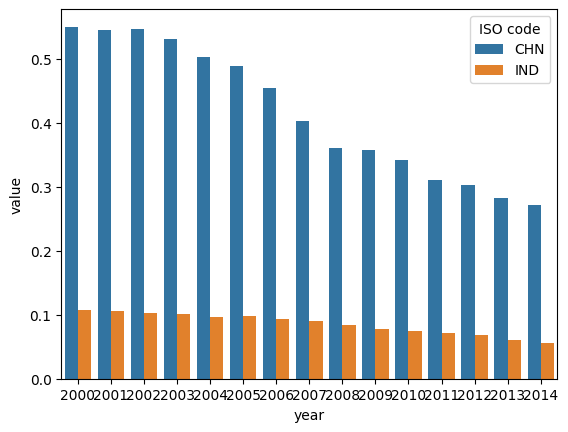

In [85]:
data_filter = PPP_exchage_filtered.loc[(PPP_exchage_filtered['ISO code'].isin(['IND','CHN']))]
sns.barplot(data=data_filter, x='year', y='value', hue='ISO code')

In [93]:
SEA.head()

,country,variable,code,year,value
0,AUS,CAP,A01,2000,5671.916100
1,AUS,CAP,A02,2000,339.327191
2,AUS,CAP,A03,2000,506.239201
3,AUS,CAP,B,2000,16451.361852
4,AUS,CAP,C10-C12,2000,3728.097564


In [102]:
%%time

ind_ppps = []
for country,dfx in tqdm(SEA.groupby('country'), unit=' country'):

    x_merge = pd.merge(left = dfx,
        right=PPP_exchage_filtered,
        left_on=dfx['year'].astype(str),
        right_on=PPP_exchage_filtered['year'].astype(str),
        how='inner',
        suffixes=('', '_y')
    )
    x_merge['tot_ind_ppp'] = x_merge['value']*x_merge['value_y']
    x_merge = x_merge.drop(['key_0','ISO code', 'Country', 'year_y', 'value', 'value_y'], axis=1)


    ind_ppps.append(x_merge)

tot_ind_ppp_df = pd.concat(ind_ppps).reset_index()
tot_ind_ppp_df.head()

100%|██████████| 43/43 [00:05<00:00,  7.59 country/s]


CPU times: user 7.2 s, sys: 2.47 s, total: 9.68 s
Wall time: 9.75 s


,index,country,variable,code,year,tot_ind_ppp
0,0,AUS,CAP,A01,2000,5989.825897
1,1,AUS,CAP,A01,2000,8208.307753
2,2,AUS,CAP,A01,2000,8061.570491
3,3,AUS,CAP,A01,2000,15200.463060
4,4,AUS,CAP,A01,2000,7673.448349


In [ ]:
data_filter

In [ ]:
data_filter = tot_ind_ppp_df.loc[(tot_ind_ppp_df['country'].isin(['CHN','IND','AUS', 'IDN', "MEX"])) & (tot_ind_ppp_df['code']=='C13-C15') & (tot_ind_ppp_df['variable']=='GO')]
sns.lineplot(data=data_filter, x='year', y='tot_ind_ppp', hue='country')

In [62]:
X1 = ppp_ratio.melt(id_vars=['code', 'variable'], value_vars=year_range)
X1.head(3)

,code,variable,year,value
0,A01,CAP,2000,1.532604
1,A01,COMP,2000,1.721800
2,A01,EMP,2000,2.065999


In [63]:
%%time

country_industry_ppp_rate_dfs = []

for country, dfx in tqdm(PPP_exchage_filtered.groupby('ISO code'), unit=' country'):
    for year in year_range:
        # X1[X1['year']==year]
        val = dfx.loc[(dfx['year']==str(year)),'value'].values[0]

        ppp_ratio_x = X1[X1['year']==year]
        rates = val*ppp_ratio_x['value'].values

        dfy = pd.DataFrame({'country_industry_ppp_rate': rates})
        dfy['country'] = country
        dfy['year'] = year
        dfy['code'] = ppp_ratio_x['code'].values
        dfy['variable'] = ppp_ratio_x['variable'].values
        dfy = dfy[['country', 'year', 'code', 'variable', 'country_industry_ppp_rate']]

        country_industry_ppp_rate_dfs.append(dfy)

country_industry_ppp_rate_df = pd.concat(country_industry_ppp_rate_dfs)
country_industry_ppp_rate_df.sample(5)

100%|██████████| 43/43 [00:03<00:00, 12.13 country/s]


CPU times: user 3.54 s, sys: 51.9 ms, total: 3.59 s
Wall time: 3.68 s


,country,year,code,variable,country_industry_ppp_rate
313,BEL,2002,C29,II_PI,1.459203
594,DNK,2010,J59_J60,EMP,0.146587
720,MLT,2005,M71,CAP,2.104629
724,AUT,2000,M71,GO,1.759796
777,LUX,2001,M74_M75,II_PI,1.529160


In [64]:
# country_industry_ppp_rate_df.to_excel('industry_ppp_rate.xlsx')

## Homogeneous Labour



In [65]:
## Homogeneous Labour with Adjusted Dollar
ppp1_GO = ppp1[ppp1['variable']=='GO'].melt(id_vars = ['code', 'variable'], value_vars=year_range)
ppp1_GO.sample(3)

## Homogeneous Labour with Standard Dollar
ppp2_GO = ppp2[ppp2['variable']=='GO'].melt(id_vars = ['code', 'variable'], value_vars=year_range)
ppp2_GO.sample(3)

,code,variable,year,value
100,M69_M70,GO,2001,1.146479e+06
498,O84,GO,2008,6.849874e+06
428,J58,GO,2007,6.379172e+05


In [66]:
hom_labour = country_industry_ppp_rate_df[country_industry_ppp_rate_df['variable']=='GO'].copy()
hom_labour['homogeneous'] = hom_labour['country_industry_ppp_rate'].values*SEA[SEA['variable']=='GO']['value'].values
hom_labour.head()

,country,year,code,variable,country_industry_ppp_rate,homogeneous
4,AUS,2000,A01,GO,1.554358,44995.481740
20,AUS,2000,A02,GO,1.339246,2017.014646
36,AUS,2000,A03,GO,1.423230,2152.468774
52,AUS,2000,B,GO,2.235083,76020.806023
68,AUS,2000,C10-C12,GO,1.362768,46563.573517


In [67]:
%%time

hom_labours = []
for country,dfx in tqdm(hom_labour.groupby('country'), unit=' country'):

    x_merge = pd.merge(left = dfx,
        right=ppp2_GO,
        left_on=dfx['year'].astype(str)+dfx['code'],
        right_on=ppp2_GO['year'].astype(str)+ppp2_GO['code'],
        how='inner',
        suffixes=('', '_y')
    )
    x_merge['h2'] = x_merge['homogeneous']/x_merge['value']
    x_merge = x_merge.drop(['key_0','code_y', 'variable_y', 'year_y', 'country_industry_ppp_rate', 'value'], axis=1)

    x_merge = pd.merge(left = x_merge,
        right=ppp1_GO,
        left_on=dfx['year'].astype(str)+dfx['code'],
        right_on=ppp1_GO['year'].astype(str)+ppp1_GO['code'],
        how='inner',
        suffixes=('', '_y')
    )
    x_merge['h3'] = x_merge['homogeneous']/x_merge['value']
    x_merge = x_merge.drop(['key_0','code_y', 'variable_y', 'year_y', 'homogeneous', 'value'], axis=1)

    hom_labours.append(x_merge)

hom_labour2 = pd.concat(hom_labours)
hom_labour2.head()

100%|██████████| 43/43 [00:00<00:00, 86.92 country/s]


CPU times: user 509 ms, sys: 4.03 ms, total: 513 ms
Wall time: 518 ms


,country,year,code,variable,h2,h3
0,AUS,2000,A01,GO,0.035176,0.051774
1,AUS,2000,A02,GO,0.016583,0.021030
2,AUS,2000,A03,GO,0.022417,0.030211
3,AUS,2000,B,GO,0.102873,0.217726
4,AUS,2000,C10-C12,GO,0.021101,0.027230


In [68]:
hom_labour2.shape

(36120, 6)

<Axes: xlabel='year', ylabel='h2'>

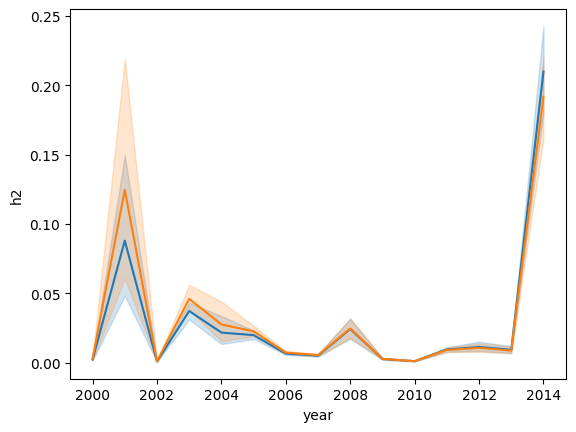

In [69]:
data_filter = hom_labour2[hom_labour2['country']=='USA']
sns.lineplot(data=data_filter, x='year', y='h2')
sns.lineplot(data=data_filter, x='year', y='h3')

## World Input Output Analysis

In [70]:
hours = SEA[SEA['variable']=='H_EMPE'].copy().drop(['country','variable'],axis=1)
hours = hours.groupby(['year','code']).sum().reset_index()
hours.sample(4)

,year,code,value
418,2007,F,59561.783357
801,2014,C27,3773.787605
736,2013,C18,2813.679336
652,2011,J58,3457.043672


In [71]:
%%time

hom_labours = []
for country,dfx in tqdm(hom_labour2.groupby('country'), unit=' country'):

    x_merge = pd.merge(left = dfx,
        right=hours,
        left_on=dfx['year'].astype(str)+dfx['code'],
        right_on=hours['year'].astype(str)+hours['code'],
        how='inner',
        suffixes=('', '_y')
    )

    x_merge['hom_labour'] = x_merge['h2']*x_merge['value']
    x_merge = x_merge.drop(['key_0','code_y', 'year_y', 'value','h2','h3'], axis=1)

    hom_labours.append(x_merge)

hom_labour3 = pd.concat(hom_labours)
hom_labour3.sample(5)

100%|██████████| 43/43 [00:00<00:00, 133.58 country/s]

CPU times: user 336 ms, sys: 7.76 ms, total: 344 ms
Wall time: 355 ms


,country,year,code,variable,hom_labour
11,BEL,2000,C21,GO,0.639040
121,CAN,2002,C19,GO,4.777086
683,IND,2012,C21,GO,0.005326
451,AUS,2008,B,GO,0.057522
614,SVN,2010,T,GO,0.000000


<Axes: xlabel='year', ylabel='hom_labour'>

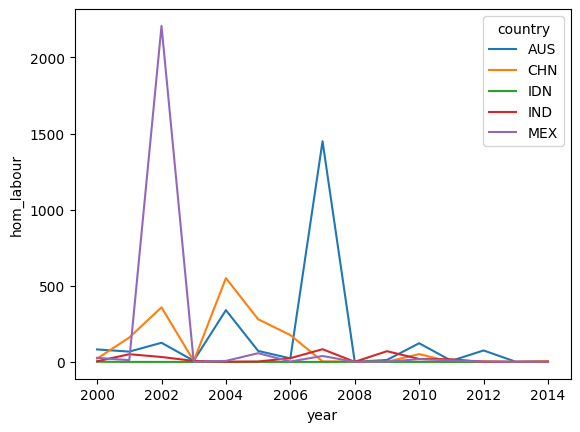

In [78]:
data_filter = hom_labour3.loc[(hom_labour3['country'].isin(['IND','CHN','AUS', 'IDN', "MEX"])) & (hom_labour3['code']=='C13-C15')]
sns.lineplot(data=data_filter, x='year', y='hom_labour', hue='country')

## Input Output Tables

In [73]:
# %%time
# df = pd.read_excel('WIOT2000_Nov16_ROW.xlsb', engine='pyxlsb')

In [74]:
# df.head(10)

In [75]:
# industries = df.iloc[5:, :3].reset_index(drop=True).copy()
# industries.columns = ['code', 'industry', 'country']
# print('Total number of industries',industries.shape[0])
# industries

In [76]:
# value = df.iloc[5:, 4:industries.shape[0]+4].copy()
# value.columns = industries['code']
# value['industry'] = industries['code']
# value['country'] = industries['country']
# value.sample(5)

In [77]:
# isProductive = ['K64', 'K65', 'K66', 'L68', 'M69_M70', 'N', 'O84', 'T', 'U']

# value[value['industry'].isin(isProductive)].groupby('country').sum().iloc[:,:-1].sum(axis=1)